In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [78]:
prop_cal   = 0.25
prop_train = 0.50

N       = 500
N_cal   = int(N * prop_cal)
N_train = int(N * prop_train)

beta = np.random.random((2))
x = np.random.random((N, 2))
y = x @ beta

x_cal, y_cal     = x[:N_cal], y[:N_cal]
x_train, y_train = x[N_cal:N_cal+N_train], y[N_cal:N_cal+N_train]
x_test, y_test   = x[N_cal+N_train:], y[N_cal+N_train:]

In [79]:
reg_0 = LinearRegression().fit(x_train[:,0:1], y_train)
reg_1 = LinearRegression().fit(x_train[:,1:2], y_train)

In [89]:
cal_scores_0 = np.abs(reg_0.predict(x_cal[:,0:1]) - y_cal)
cal_scores_1 = np.abs(reg_1.predict(x_cal[:,1:2]) - y_cal)
cal_scores   = np.vstack([cal_scores_0, cal_scores_1]).T

In [90]:
test_scores_0 = np.abs(reg_0.predict(x_test[:,0:1]) - y_test)
test_scores_1 = np.abs(reg_1.predict(x_test[:,1:2]) - y_test)
test_scores   = np.vstack([test_scores_0, test_scores_1]).T

In [91]:
alpha = 0.05
quantile_0 = np.quantile(cal_scores_0, q = 1 - alpha)
quantile_1 = np.quantile(cal_scores_1, q = 1 - alpha)

In [92]:
print(f"Covered : {np.sum(test_scores_0 < quantile_0) / len(test_scores_0)}")
print(f"Covered : {np.sum(test_scores_1 < quantile_1) / len(test_scores_1)}")

Covered : 0.944
Covered : 0.952


In [147]:
M = 12 # number of angle discretizations
directions, envelope_pts, quantiles = [], [], []
for m in range(M):
    angle = 2 * np.pi * m / M
    direction   = np.array([np.cos(angle), np.sin(angle)])
    proj_scores = np.dot(cal_scores, direction)
    quantile    = np.quantile(proj_scores, q = 1 - alpha)

    sorted_scores = np.argsort(proj_scores)
    quantile_idx  = int((1 - alpha) * N_cal)
    
    directions.append(direction)
    envelope_pts.append(cal_scores[sorted_scores[quantile_idx]])
    quantiles.append(quantile)
directions, envelope_pts, quantiles = np.array(directions), np.array(envelope_pts), np.array(quantiles)

In [148]:
proj_test_scores = np.array([np.dot(test_scores, direction) for direction in directions]).T

In [155]:
contained = np.all(proj_test_scores < quantiles, axis=1)
percent_contained = np.sum(contained) / len(proj_test_scores)
print(f"Contained: {percent_contained}")

Contained: 0.672


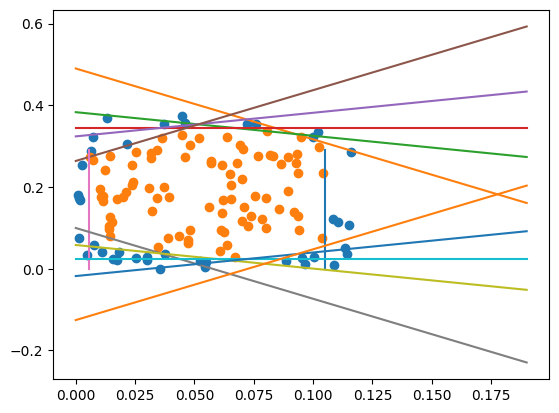

In [171]:
for m in range(M):
    if abs(directions[m][1]) < 0.001: # special case of vertical line
        ys = np.arange(0, 0.3, 0.01)
        xs = np.ones(ys.shape) * envelope_pts[m][0]
    else:
        xs = np.arange(0, 0.2, 0.01)
        ys = -(directions[m][0] / directions[m][1]) * (xs - envelope_pts[m][0]) + envelope_pts[m][1]
    plt.plot(xs, ys)

plt.scatter(test_scores[~contained][:,0],test_scores[~contained][:,1])
plt.scatter(test_scores[contained][:,0], test_scores[contained][:,1])

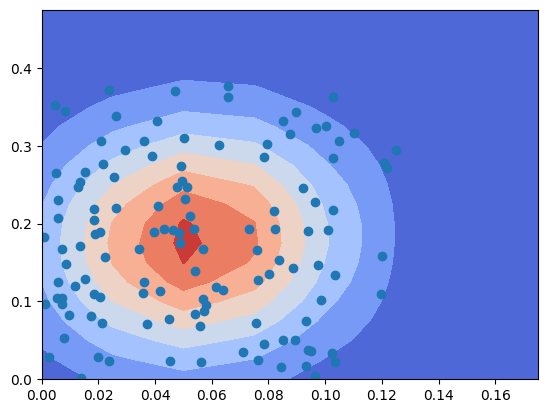

In [179]:
from scipy.stats import multivariate_normal

mean = np.mean(cal_scores, axis=0)
cov  = np.cov(cal_scores, rowvar=0)

x, y = np.mgrid[0:.2:.025, 0:.5:.025]
rv = multivariate_normal(mean, cov)
data = np.dstack((x, y))
z = rv.pdf(data)
plt.contourf(x, y, z, cmap='coolwarm')
plt.scatter(cal_scores[:,0],cal_scores[:,1])